In [ ]:
!pip install datasets --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict,load_dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score,accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# load model

In [ ]:
# 4. Initialize classification model
classification_model = TFAutoModelForSequenceClassification.from_pretrained(
    "pysentimiento/robertuito-base-uncased",
    num_labels=5,
    output_attentions=True,
    ignore_mismatched_sizes=True  # Required for architecture change
)

tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/HateMedia/Modelos/OdioNoOdio/Final/hate-trained-robertuito_OdioNoOdio_final_new_cardiff_extra_layer_tokenizer")
tokenizer.model_max_length = 128

classification_model.get_layer('roberta').trainable = True
classification_model.get_layer('classifier').trainable = True

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
# Re-define the model architecture
num_labels = 5
# set input ids as input
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')

# set attention mask as input
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# modify the model
output = classification_model(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels)(output[:, :])

# set the model to its final form
classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

In [ ]:
# Rebuild the model architecture first
classification_model.load_weights("/content/drive/MyDrive/HateMedia/Modelos/OdioNoOdio/Final/hate-trained-robertuito_OdioNoOdio_final_new_cardiff_extra_layer.h5",skip_mismatch=True, by_name=True)

In [ ]:
classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1087910   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    45         'attention_mask[0][0]']      
 SequenceClassification)     5),                                                              

# Read data

In [ ]:
# Preprocess data function to create TensorFlow datasets
def preprocess_data(split_df,num_labels):
# Tokenize the texts and set maximum length, truncation and padding size
  texts = split_df['text'].tolist()
  encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=128,return_token_type_ids=False)

# Convert the labels to one-hot encoding
  labels = split_df['label'].tolist()
  labels_encoded = tf.one_hot(labels, num_labels)

# Create TensorFlow datasets
  dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels_encoded))

  return dataset

In [ ]:
df_in = pd.read_csv('/content/drive/MyDrive/HateMedia/Data/Procesada/Tipos/df_tipos_merged.csv')
df_in = df_in.dropna(subset=['message'])
df_in = df_in.dropna(subset=['TIPO DE ODIO'])
df_in = df_in.reset_index(drop=True)
df_in = df_in.rename(columns={'message': 'text','TIPO DE ODIO': 'label'})
df_in = df_in[['text','label']]
df_in['label'] = df_in['label'] -1
df_in['label'] = df_in['label'].astype(int)
df_in

,text,label
0,@usuario marlasca maricon hdlgp !!!,1
1,@usuario sánchez cabronazo maricon deja de jod...,1
2,@usuario putos dictadores comunistas zurrapast...,1
3,@usuario la gente es gilipollas comprar mierda...,1
4,@usuario @usuario la imagen del rey tapándose ...,1
...,...,...
1076944,Pero no toqué en la Juventus.,5
1076945,goldman Sachs o libertad,5
1076946,El aborto es un asesinato y lo que pasa es un ...,5
1076947,"el odio, pero el odio de la",5


In [ ]:
df_in = df_in.loc[df_in['label'] != 2]

In [ ]:
# see class distribution
df_in['label'].value_counts()

,count
label,
1,416678
0,284039
3,142037
4,123895
5,110103


In [ ]:
df_in.loc[df_in['label'] == 5, 'label'] = 2

In [ ]:
# see class distribution
df_in['label'].value_counts()

,count
label,
1,416678
0,284039
3,142037
4,123895
2,110103


In [ ]:
# Split your DataFrame
train_df, temp_df = train_test_split(df_in, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# convert to tensorflow, tokenize and create datasets in trainable format
num_labels = len(df_in['label'].unique())
train_dataset = preprocess_data(train_df,num_labels)
test_dataset = preprocess_data(test_df,num_labels)
val_dataset = preprocess_data(val_df,num_labels)


In [ ]:
# n_samples / (n_classes * np.bincount(y))
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(train_df['label']), y=train_df['label'])
class_weight = np.round(class_weight,2).tolist()
class_weight = {i: class_weight[i] for i in range(len(class_weight))}
class_weight

{0: 0.76, 1: 0.52, 2: 1.95, 3: 1.51, 4: 1.73}

# Train

In [ ]:
# create a warmup schedule
class WarmupLinearSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, max_lr=2e-5):
        super().__init__()
        # cast warmup_steps and max_lr to float to tensorflow format
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        self.max_lr = max_lr

    def __call__(self, step):
        # cast step to tensorflow format
        step = tf.cast(step, tf.float32)
        # Linear warmup
        lr = self.max_lr * (step / self.warmup_steps)
        # After warmup, keep constant LR
        return tf.minimum(lr, self.max_lr)

In [ ]:
# Calculate training parameters
batch_size = 128
epochs = 5
steps_per_epoch = len(train_df) // batch_size
total_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * total_steps)  # 10% warmup
print("total_steps:",total_steps,"- warmup_steps:",warmup_steps)

total_steps: 33645 - warmup_steps: 3364


In [ ]:
# Initialize optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=WarmupLinearSchedule(
        warmup_steps=warmup_steps,
        max_lr=2e-5))

# Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score',
    mode='max',
    restore_best_weights=True,
    patience=2,
    verbose=1)

In [ ]:
# Compile model
classification_model.compile(
    optimizer=optimizer,  # Pass the optimizer instance directly
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.Recall(name='recall', class_id=2), # Focus on 2
             tf.keras.metrics.Precision(name='precision', class_id=3), # Focus on 3
             tf.keras.metrics.Accuracy(name='accuracy'),
             tf.keras.metrics.F1Score(name="f1_score", average='weighted'), # Use weighted average for f1_score
             tf.keras.metrics.AUC(name='AUC', curve='PR'),
             tf.keras.metrics.RecallAtPrecision(precision=0.6, name='recall_at_precision', class_id=3), # Focus on 3
             tf.keras.metrics.PrecisionAtRecall(recall=0.6, class_id=2)]) # Focus on )



# Train model
history = classification_model.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    batch_size=batch_size,
    class_weight=class_weight,
    callbacks=callback,
    epochs=epochs)

# Epoch 3/5
# 6731/6731 [==============================] - 2211s 329ms/step - loss: 0.9018 - recall: 0.9735 - precision: 0.1633 - accuracy: 0.0000e+00 - f1_score: 0.6445 - AUC: 0.2808 - recall_at_precision: 0.0000e+00 - precision_at_recall: 0.0179 - val_loss: 1.0580 - val_recall: 0.5926 - val_precision: 0.1621 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6448 - val_AUC: 0.2772 - val_recall_at_precision: 0.0000e+00 - val_precision_at_recall: 0.0161

Epoch 1/5
6730/6730 [==============================] - 2267s 330ms/step - loss: 1.1698 - recall: 0.6736 - precision: 0.1544 - accuracy: 0.0000e+00 - f1_score: 0.5665 - AUC: 0.2957 - recall_at_precision: 0.0000e+00 - precision_at_recall: 0.1713 - val_loss: 1.0175 - val_recall: 0.7298 - val_precision: 0.1444 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6559 - val_AUC: 0.3024 - val_recall_at_precision: 0.0000e+00 - val_precision_at_recall: 0.1719
Epoch 2/5
6730/6730 [==============================] - 2218s 330ms/step - loss: 1.0095 - recall: 0.7720 - precision: 0.1537 - accuracy: 0.0000e+00 - f1_score: 0.6606 - AUC: 0.3011 - recall_at_precision: 0.0000e+00 - precision_at_recall: 0.1783 - val_loss: 0.9956 - val_recall: 0.7455 - val_precision: 0.1516 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6657 - val_AUC: 0.3025 - val_recall_at_precision: 0.0000e+00 - val_precision_at_recall: 0.1686
Epoch 3/5
6730/6730 [==============================] - 2217s 329ms/step - loss: 0.9540 - recall: 0.7833 

In [ ]:
# save model weights
classification_model.save_weights("***/Tipos-trained-robertuito_base_odio_bin__sin_rel_pt1.h5")

# save tokenizer
tokenizer.save_pretrained("***/Tipos-trained-robertuito_base_odio_bin_tokenizer__sin_rel_pt1")

('/content/drive/MyDrive/HateMedia/Modelos/Tipos/Tipos-trained-robertuito_base_odio_bin_tokenizer__sin_rel_pt1/tokenizer_config.json',
 '/content/drive/MyDrive/HateMedia/Modelos/Tipos/Tipos-trained-robertuito_base_odio_bin_tokenizer__sin_rel_pt1/special_tokens_map.json',
 '/content/drive/MyDrive/HateMedia/Modelos/Tipos/Tipos-trained-robertuito_base_odio_bin_tokenizer__sin_rel_pt1/tokenizer.json')

In [ ]:
# Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    restore_best_weights=True,
    patience=2,
    verbose=1)

In [ ]:
# Compile model
classification_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),  # Pass the optimizer instance directly
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.Recall(name='recall', class_id=2), # Focus on 2
             tf.keras.metrics.Precision(name='precision', class_id=3), # Focus on 3
             tf.keras.metrics.Accuracy(name='accuracy'),
             tf.keras.metrics.F1Score(name="f1_score", average='weighted'), # Use weighted average for f1_score
             tf.keras.metrics.AUC(name='AUC', curve='PR'),
             tf.keras.metrics.RecallAtPrecision(precision=0.9, name='recall_at_precision', class_id=3), # Focus on 3
             tf.keras.metrics.PrecisionAtRecall(recall=0.9, class_id=2)]) # Focus on )



# Train model
history = classification_model.fit(
    train_dataset.batch(batch_size),
    validation_data=val_dataset.batch(batch_size),
    batch_size=batch_size,
    class_weight=class_weight,
    callbacks=callback,
    epochs=epochs)

# Epoch 2/5
# 6731/6731 [==============================] - 2206s 328ms/step - loss: 0.8222 - recall: 0.9735 - precision: 0.1653 - accuracy: 0.0000e+00 - f1_score: 0.6795 - AUC: 0.2805 - recall_at_precision: 0.0000e+00 - precision_at_recall_1: 0.0130 - val_loss: 1.0533 - val_recall: 0.6296 - val_precision: 0.1629 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6482 - val_AUC: 0.2754 - val_recall_at_precision: 0.0000e+00 - val_precision_at_recall_1: 0.0000e+00


Epoch 1/5
6730/6730 [==============================] - 2259s 330ms/step - loss: 0.9566 - recall: 0.7815 - precision: 0.1611 - accuracy: 0.0000e+00 - f1_score: 0.6818 - AUC: 0.3054 - recall_at_precision: 0.0000e+00 - precision_at_recall_1: 0.0000e+00 - val_loss: 1.0116 - val_recall: 0.6980 - val_precision: 0.1603 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6625 - val_AUC: 0.3028 - val_recall_at_precision: 0.0000e+00 - val_precision_at_recall_1: 0.0000e+00
Epoch 2/5
6730/6730 [==============================] - 2214s 329ms/step - loss: 0.9021 - recall: 0.7920 - precision: 0.1698 - accuracy: 0.0000e+00 - f1_score: 0.7030 - AUC: 0.3114 - recall_at_precision: 0.0000e+00 - precision_at_recall_1: 0.0000e+00 - val_loss: 1.0117 - val_recall: 0.7186 - val_precision: 0.1568 - val_accuracy: 0.0000e+00 - val_f1_score: 0.6644 - val_AUC: 0.3014 - val_recall_at_precision: 0.0000e+00 - val_precision_at_recall_1: 0.0000e+00
Epoch 3/5
6730/6730 [==============================] - 2214s 329ms/step - loss: 

In [ ]:
# Rebuild the model architecture first
classification_model.load_weights("***/Tipos-trained-robertuito_base_odio_bin__sin_rel_pt1.h5")#,skip_mismatch=True, by_name=True)

# Results

In [61]:
# make predictions
predictions = classification_model.predict(test_dataset.batch(batch_size))

842/842 [==============================] - 95s 109ms/step


In [62]:
# Get true labels from test_df
y_true = test_df['label']

# Get predictions from your model
y_pred = tf.argmax(predictions, axis=1)  # predictions contains probabilities/logits

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[20997,  3893,   707,  1663,  1158],
       [ 5141, 28395,  2454,  2963,  3014],
       [  818,  1876,  6419,   788,  1055],
       [ 1641,  1936,   907,  8874,   729],
       [  978,  1767,  1402,   702,  7399]])

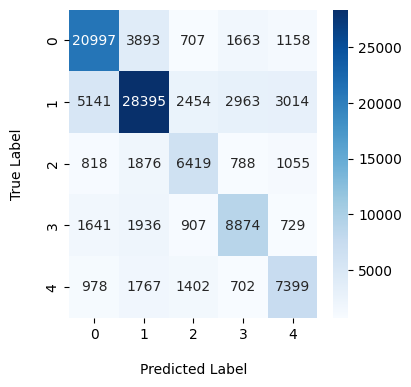

In [63]:
# plot confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("\nPredicted Label")
plt.ylabel("True Label\n")
plt.show()

In [64]:
# Get true labels from test_ds and convert to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_labels)

# For other metrics, get predicted class labels
y_pred = tf.argmax(predictions, axis=1)  # predictions contains probabilities/logits


# Calculate metrics
metrics = {
    "Recall (Macro)": recall_score(y_true, y_pred, average='macro'),
    "Precision (Macro)": precision_score(y_true, y_pred, average='macro'),
    "F1 (Macro)": f1_score(y_true, y_pred, average='macro'),
    "AUC (OvR)": roc_auc_score(y_true_one_hot, predictions, multi_class='ovr'),  # Use one-hot encoded y_true and y_score
    "Accuracy": accuracy_score(y_true, y_pred)
}

# For per-class metrics
per_class_metrics = {
    "Recall (Per Class)": recall_score(y_true, y_pred, average=None),
    "Precision (Per Class)": precision_score(y_true, y_pred, average=None),
    "F1 (Per Class)": f1_score(y_true, y_pred, average=None)
}

# Print results
print("Aggregate Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\nPer-Class Metrics:")
for i, (rec, prec, f1) in enumerate(zip(per_class_metrics["Recall (Per Class)"],
                                      per_class_metrics["Precision (Per Class)"],
                                      per_class_metrics["F1 (Per Class)"])):
    print(f"Class {i}: Recall={rec:.4f}, Precision={prec:.4f}, F1={f1:.4f}")

print(classification_report(y_true, y_pred))

Aggregate Metrics:
Recall (Macro): 0.6471
Precision (Macro): 0.6291
F1 (Macro): 0.6372
AUC (OvR): 0.7090
Accuracy: 0.6695

Per-Class Metrics:
Class 0: Recall=0.7389, Precision=0.7100, F1=0.7241
Class 1: Recall=0.6766, Precision=0.7499, F1=0.7114
Class 2: Recall=0.5859, Precision=0.5399, F1=0.5620
Class 3: Recall=0.6299, Precision=0.5920, F1=0.6104
Class 4: Recall=0.6041, Precision=0.5540, F1=0.5780
              precision    recall  f1-score   support

           0       0.71      0.74      0.72     28418
           1       0.75      0.68      0.71     41967
           2       0.54      0.59      0.56     10956
           3       0.59      0.63      0.61     14087
           4       0.55      0.60      0.58     12248

    accuracy                           0.67    107676
   macro avg       0.63      0.65      0.64    107676
weighted avg       0.68      0.67      0.67    107676



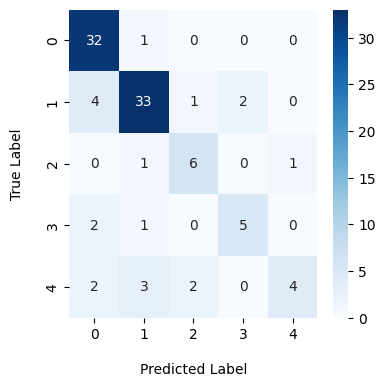

In [65]:
# Get true labels from test_df
y_true = test_df['label']

# Get predictions from your model
y_pred = tf.argmax(predictions, axis=1)  # predictions contains probabilities/logits

# calculate confusion matrix
cm = confusion_matrix(y_true[200:300], y_pred[200:300])

# plot confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("\nPredicted Label")
plt.ylabel("True Label\n")
plt.show()

In [66]:
# Get true labels from test_ds and convert to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_labels)

# For other metrics, get predicted class labels
y_pred = tf.argmax(predictions, axis=1)  # predictions contains probabilities/logits

# Calculate metrics
metrics = {
    "Recall (Macro)": recall_score(y_true[200:300], y_pred[200:300], average='macro'),
    "Precision (Macro)": precision_score(y_true[200:300], y_pred[200:300], average='macro'),
    "F1 (Macro)": f1_score(y_true[200:300], y_pred[200:300], average='macro'),
    "AUC (OvR)": roc_auc_score(y_true_one_hot[200:300], predictions[200:300], multi_class='ovr'),  # Use one-hot encoded y_true and y_score
    "Accuracy": accuracy_score(y_true[200:300], y_pred[200:300])
}

# For per-class metrics
per_class_metrics = {
    "Recall (Per Class)": recall_score(y_true[200:300], y_pred[200:300], average=None),
    "Precision (Per Class)": precision_score(y_true[200:300], y_pred[200:300], average=None),
    "F1 (Per Class)": f1_score(y_true[200:300], y_pred[200:300], average=None)
}

# Print results
print("Aggregate Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\nPer-Class Metrics:")
for i, (rec, prec, f1) in enumerate(zip(per_class_metrics["Recall (Per Class)"][1111:1211],
                                      per_class_metrics["Precision (Per Class)"][1111:1211],
                                      per_class_metrics["F1 (Per Class)"][1111:1211])):
    print(f"Class {i}: Recall={rec:.4f}, Precision={prec:.4f}, F1={f1:.4f}")

print(classification_report(y_true[200:300], y_pred[200:300]))

Aggregate Metrics:
Recall (Macro): 0.7067
Precision (Macro): 0.7654
F1 (Macro): 0.7169
AUC (OvR): 0.7314
Accuracy: 0.8000

Per-Class Metrics:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        33
           1       0.85      0.82      0.84        40
           2       0.67      0.75      0.71         8
           3       0.71      0.62      0.67         8
           4       0.80      0.36      0.50        11

    accuracy                           0.80       100
   macro avg       0.77      0.71      0.72       100
weighted avg       0.80      0.80      0.79       100



In [ ]:
history.history

# Save the model

In [67]:
# Print the model summary
classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1087910   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    45         'attention_mask[0][0]']      
 SequenceClassification)     5),                                                              

In [ ]:
# save model history (models metrics while training) to csv file
history_df = pd.DataFrame(history.history)
history_df.to_csv('***/_history_Tipos-trained-robertuito_base_odio_bin.csv')

In [ ]:
# save model weights
classification_model.save_weights("***/Tipos-trained-robertuito_base_odio_bin.h5")

# save tokenizer
tokenizer.save_pretrained("***/Tipos-trained-robertuito_base_odio_bin_tokenizer")

# requirements

In [68]:
# save requirements as a txt file
!pip freeze > requirements.txt

In [ ]:
requirements = pd.read_csv('/content/requirements.txt', header=None)
requirements.to_csv('***/requirements.csv', index=False)

In [71]:
from google.colab import runtime
runtime.unassign()